In [9]:
import torch
import random
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from argparse import ArgumentParser
from tensorboardX import SummaryWriter
import sys
from models.factorizer import setup_factorizer
from data_loader.data_loader import setup_generator
from utils.evaluate import evaluate_fm
import warnings


In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.backends.cudnn.enabled = True


In [14]:

def setup_args(parser=None):
    """ Set up arguments for the Engine

    return:
        python dictionary
    """
    if parser is None:
        parser = ArgumentParser()
    data = parser.add_argument_group('Data')
    engine = parser.add_argument_group('Engine Arguments')
    factorize = parser.add_argument_group('Factorizer Arguments')
    matrix_factorize = parser.add_argument_group('MF Arguments')
    regularize = parser.add_argument_group('Regularizer Arguments')
    log = parser.add_argument_group('Tensorboard Arguments')

    engine.add_argument('--alias', default='experiment',
                        help='Name for the experiment')
    engine.add_argument('--seed', default='42')

    data.add_argument('--data-type', default='ml1m', help='type of the dataset')
    data.add_argument('--data-path', default='./data/{data_type}/')
    data.add_argument('--train_test-freq-bd', help='split the data freq-wise, bound of the user freq')
    data.add_argument('--train-valid-freq-bd', help='split the data freq-wise, bound of the user freq')
    data.add_argument('--batch-size-train', default=1)
    data.add_argument('--batch-size-valid', default=1)
    data.add_argument('--batch-size-test', default=1)
    data.add_argument('--device-ids-test', default=[0], help='devices used for multi-processing evaluate')

    regularize.add_argument('--max-steps', default=1e5)
    regularize.add_argument('--max-epochs', default=50)
    regularize.add_argument('--use-cuda', default=True)
    regularize.add_argument('--device-id', default=0, help='Training Devices')

    factorize.add_argument('--factorizer', default='fm', help='Type of the Factorization Model')
    factorize.add_argument('--latent-dim', default=8)

    type_opt = 'fm'
    matrix_factorize.add_argument('--{}-optimizer'.format(type_opt), default='sgd')
    matrix_factorize.add_argument('--{}-lr'.format(type_opt), default=1e-3)
    matrix_factorize.add_argument('--{}-grad-clip'.format(type_opt), default=1)

    log.add_argument('--log-interval', default=1)
    log.add_argument('--tensorboard', default='./tmp/runs')
    log.add_argument('--early_stop', default=None)
    log.add_argument('--display_interval', default=100)
    return parser





In [23]:
class Engine(object):
    """Engine wrapping the training & evaluation
       of adpative regularized maxtirx factorization
    """
    _global_writer = None  # Class variable for the global writer
    _param_step = 0  # Class variable to track parameter steps


    def __init__(self, opt):
        self._opt = opt
        self._opt['data_path'] = self._opt['data_path'].format(data_type=self._opt['data_type'])
        self._sampler = setup_generator(opt)

        self._opt['field_dims'] = self._sampler.field_dims

        if Engine._global_writer is None:
            Engine._global_writer = SummaryWriter(log_dir='{}/parameter_comparison'.format(self._opt['tensorboard']))
        

        self._opt['emb_save_path'] = self._opt['emb_save_path'].format(
            factorizer=self._opt['factorizer'],
            data_type=self._opt['data_type'],
            alias=self._opt['alias'],
            num_parameter='{num_parameter}'
        )
        if 'retrain_emb_param' in opt:
            self.retrain = True
            if opt['re_init']:
                self._opt['alias'] += '_reinitTrue'
            else:
                self._opt['alias'] += '_reinitFalse'
            self._opt['alias'] += '_retrain_emb_param{}'.format(opt['retrain_emb_param'])
        else:
            self.retrain = False
            self.candidate_p = self._opt.get('candidate_p')
        self._opt['eval_res_path'] = self._opt['eval_res_path'].format(
            factorizer=self._opt['factorizer'],
            data_type=self._opt['data_type'],
            alias=self._opt['alias'],
            epoch_idx='{epoch_idx}'
        )
        self._factorizer = setup_factorizer(opt)
        self._opt['tensorboard'] = self._opt['tensorboard'].format(
            factorizer=self._opt['factorizer'],
            data_type=self._opt['data_type'],
        )
        self._writer = SummaryWriter(log_dir='{}/{}'.format(self._opt['tensorboard'], opt['alias']))
        self._writer.add_text('option', str(opt), 0)
        self._mode = None
        self.early_stop = self._opt.get('early_stop')


    @property
    def mode(self):
        return self._mode

    @mode.setter
    def mode(self, new_mode):
        assert new_mode in ['complete', 'partial', None]  # training a complete trajectory or a partial trajctory
        self._mode = new_mode

    def save_pruned_embedding(self, param, step_idx):
        max_candidate_p = max(self.candidate_p)
        if max_candidate_p == 0:

            print("Minimal target parameters achieved, stop pruning.")
            return 0

        else:
            if param <= max_candidate_p:
                embedding = self._factorizer.model.get_embedding()
                emb_save_path = self._opt['emb_save_path'].format(num_parameter=param)
                emb_save_dir, _ = os.path.split(emb_save_path)
                if not os.path.exists(emb_save_dir):
                    os.makedirs(emb_save_dir)
                np.save(emb_save_path, embedding)
                max_idx = self.candidate_p.index(max(self.candidate_p))
                self.candidate_p[max_idx] = 0
                print("*" * 80)
                print("Reach the target parameter: {}, save embedding with size: {}".format(max_candidate_p, param))
                print("*" * 80)
            elif step_idx == 0:
                embedding = self._factorizer.model.get_embedding()
                emb_save_path = self._opt['emb_save_path'].format(num_parameter='initial_embedding')
                emb_save_dir, _ = os.path.split(emb_save_path)
                if not os.path.exists(emb_save_dir):
                    os.makedirs(emb_save_dir)
                np.save(emb_save_path, embedding)
                print("*" * 80)
                print("Save the initial embedding table")
                print("*" * 80)
        return 1
    
    def train_an_episode(self, max_steps, max_epochs, episode_idx=''):
        """Train a feature_based recommendation model"""
        assert self.mode in ['partial', 'complete']

        print('-' * 80)
        print('[{} episode {} starts!]'.format(self.mode, episode_idx))
        print('Initializing ...')
        self._factorizer.init_episode()

        log_interval = self._opt.get('log_interval')
        eval_interval = self._opt.get('eval_interval')
        display_interval = self._opt.get('display_interval')

        status = dict()
        flag, test_flag, valid_flag = 0, 0, 0
        valid_mf_loss, train_mf_loss = np.inf, np.inf
        best_valid_result = {"AUC": [0, 0], "LogLoss": [np.inf, 0]}
        best_test_result = {"AUC": [0, 0], "LogLoss": [np.inf, 0]}
        epoch_start = datetime.now()
        for step_idx in range(int(max_steps)):
            # Prepare status for current step
            status['done'] = False
            status['sampler'] = self._sampler
            train_mf_loss = self._factorizer.update(self._sampler)
            status['train_mf_loss'] = train_mf_loss

            # Logging & Evaluate on the Evaluate Set
            if self.mode == 'complete' and step_idx % log_interval == 0:
                epoch_idx = int(step_idx / self._sampler.num_batches_train)
                if epoch_idx > max_epochs and self.retrain:
                    return best_test_result

                sparsity, params = self._factorizer.model.calc_sparsity()
                if not self.retrain:
                    returnflag = self.save_pruned_embedding(params, step_idx)
                    if not returnflag:
                        return best_test_result
                    
                self._writer.add_scalar('train/step_wise/mf_loss', train_mf_loss, step_idx)
                self._writer.add_scalar('train/step_wise/sparsity', sparsity, step_idx)

                if step_idx % display_interval == 0:
                    print('[Epoch {}|Step {}|Flag {}|Sparsity {:.4f}|Params {}]'.format(epoch_idx,
                                                                                        step_idx % self._sampler.num_batches_train,
                                                                                        flag, sparsity, params))

                if step_idx % self._sampler.num_batches_train == 0:
                    threshold = self._factorizer.model.get_threshold()

                    self._writer.add_histogram('threshold/epoch_wise/threshold', threshold, epoch_idx)
                    self._writer.add_scalar('train/epoch_wise/sparsity', sparsity, epoch_idx)
                    self._writer.add_scalar('train/epoch_wise/params', params, epoch_idx)

                if (step_idx % self._sampler.num_batches_train == 0) and (epoch_idx % eval_interval == 0) and self.retrain:
                    print('Evaluate on test ...')
                    start = datetime.now()
                    eval_res_path = self._opt['eval_res_path'].format(epoch_idx=epoch_idx)
                    eval_res_dir, _ = os.path.split(eval_res_path)
                    if not os.path.exists(eval_res_dir):
                        os.makedirs(eval_res_dir)

                    use_cuda = self._opt['use_cuda']
                    logloss, auc = evaluate_fm(self._factorizer, self._sampler, use_cuda)
                    self._writer.add_scalar('test/epoch_wise/metron_auc', auc, epoch_idx)
                    self._writer.add_scalar('test/epoch_wise/metron_logloss', logloss, epoch_idx)
                    if logloss < best_test_result['LogLoss'][0]:
                        best_test_result['LogLoss'][0] = logloss
                        best_test_result['LogLoss'][1] = epoch_idx
                    if auc > best_test_result['AUC'][0]:
                        best_test_result['AUC'][0] = auc
                        best_test_result['AUC'][1] = epoch_idx
                        test_flag = 0
                    else:
                        test_flag += 1
                    pd.Series(best_test_result).to_csv(eval_res_path)
                    print("*" * 80)
                    print("Test AUC: {:4f} | Logloss: {:4f}".format(auc, logloss))
                    end = datetime.now()
                    print('Evaluate Time {} minutes'.format((end - start).total_seconds() / 60))
                    epoch_end = datetime.now()
                    dur = (epoch_end - epoch_start).total_seconds() / 60
                    epoch_start = datetime.now()
                    print('[Epoch {:4d}] train MF loss: {:04.8f}, '
                          'valid loss: {:04.8f}, time {:04.8f} minutes'.format(epoch_idx,
                                                                               train_mf_loss,
                                                                               valid_mf_loss,
                                                                               dur))
                    print("*"*80)
                    
            flag = test_flag
            if self.early_stop is not None and flag >= self.early_stop :
                print("Early stop training process")
                print("Best performance on test data: ", best_test_result)
                print("Best performance on valid data: ", best_valid_result)
                self._writer.add_text('best_valid_result', str(best_valid_result), 0)
                self._writer.add_text('best_test_result', str(best_test_result), 0)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    return best_test_result
                
            
            
    def train_finish(self, best_test_result):
        Engine._global_writer.add_scalar(
            'parameter_comparison/best_auc_vs_params', 
            best_test_result['AUC'][0],
            Engine._param_step
        )
        Engine._param_step += 1  # Increment the step counter
        Engine._global_writer.flush()

    def __del__(self):
        if hasattr(self, '_writer'):
            self._writer.close()
        if Engine._global_writer is not None:  # Close global writer if exists
            Engine._global_writer.close()





    def train(self):
        self.mode = 'complete'
        best_test_result = self.train_an_episode(self._opt['max_steps'],self._opt['max_epochs'])
        return best_test_result




# Train FM, with MovieLense Dataset

In [16]:

torch.cuda.empty_cache()


parser = setup_args()
parser.set_defaults(
    alias='train',
    tensorboard='./tmp/runs/{factorizer}/{data_type}',
    ##########
    ## data ##
    ##########
    data_type='ml-1m',
    data_path='./data/{data_type}/',
    load_in_queue=False,
    category_only=False,
    rebuild_cache=False,
    eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
    emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
    ######################
    ## train/test split ##
    ######################
    test_ratio=0.1,
    valid_ratio=1/9,
    ##########################
    ## Devices & Efficiency ##
    ##########################
    use_cuda=True,
    early_stop=10,
    log_interval=1,
    display_interval=500,
    eval_interval=5,  # 10 epochs between 2 evaluations
    device_ids_test=[0],
    device_id=0,
    batch_size_train=1024,
    batch_size_valid=1024,
    batch_size_test=1024,
    ###########
    ## Model ##
    ###########
    factorizer='fm',
    model='fm',
    fm_lr=1e-3,
    # Deep
    mlp_dims=[100, 100],
    # AutoInt
    has_residual=True,
    full_part=True,
    num_heads=2,
    num_layers=3,
    att_dropout=0.4,
    atten_embed_dim=64,
    # optimizer setting
    fm_optimizer='adam',
    fm_amsgrad=False,
    fm_eps=1e-8,
    fm_l2_regularization=1e-5,
    fm_betas=(0.9, 0.999),
    fm_grad_clip=100,  # 0.1
    fm_lr_exp_decay=1,
    l2_penalty=0,
    #########
    ## Embeddings//PEP ##
    #########
    latent_dim=32,
    threshold_type='feature_dim',
    g_type='sigmoid',
    gk=1,
    threshold_init=-15,
    candidate_p=[50000, 30000, 20000],
)

opt = parser.parse_args(args=[])
opt = vars(opt)

# rename alias

opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
    opt['model'].upper(),
    opt['alias'],
    opt['latent_dim'],
    opt['batch_size_train'],
    opt['fm_lr'],
    opt['fm_optimizer'],
    opt['threshold_type'].upper(),
    opt['threshold_init'],
    opt['g_type'],
    opt['gk'],
    opt['l2_penalty']
)
print(opt['alias'])
random.seed(opt['seed'])
# np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
torch.cuda.manual_seed_all(opt['seed'])
engine = Engine(opt)
best_result = engine.train()
print("*"*10 , best_result, "*"*10)



FM_train_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
BackBone Embedding Parameters:  132128
********************************************************************************
Save the initial embedding table
********************************************************************************
[Epoch 0|Step 0|Flag 1|Sparsity 0.0000|Params 132128]


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0|Step 500|Flag 1|Sparsity 0.0055|Params 131406]


KeyboardInterrupt: 

# Retrain FM, with MovieLense Dataset

In [17]:
target_parameters = [20000, 29997, 49997]
best_test_results_list = []
for target_param in target_parameters:

    print(f"retrain for target parameters {target_param}")
    parser = setup_args()
    parser.set_defaults(
        alias='test',
        tensorboard='./tmp/runs/{factorizer}/{data_type}',
        ##########
        ## data ##
        ##########
        data_type='ml-1m',
        data_path='./data/{data_type}/',
        load_in_queue=False,
        category_only=False,
        rebuild_cache=False,
        eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
        emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
        ######################
        ## train/test split ##
        ######################
        test_ratio=0.1,
        valid_ratio=1/9,
        ##########################
        ## Devices & Efficiency ##
        ##########################
        use_cuda=True,
        early_stop=40,
        log_interval=1,
        display_interval=500,
        eval_interval=5,  # 10 epochs between 2 evaluations
        device_ids_test=[0],
        device_id=0,
        batch_size_train=1024,
        batch_size_valid=1024,
        batch_size_test=1024,
        ###########
        ## Model ##
        ###########
        factorizer='fm',
        model='fm',
        fm_lr=1e-3,
        # Deep
        mlp_dims=[100, 100],
        # AutoInt
        has_residual=True,
        full_part=True,
        num_heads=2,
        num_layers=3,
        att_dropout=0.4,
        atten_embed_dim=64,
        # optimizer setting
        fm_optimizer='adam',
        fm_amsgrad=False,
        fm_eps=1e-8,
        fm_l2_regularization=1e-5,
        fm_betas=(0.9, 0.999),
        fm_grad_clip=100,  # 0.1
        fm_lr_exp_decay=1,
        l2_penalty=0,
        #########
        ## PEP ##
        #########
        latent_dim=32,
        threshold_type='feature_dim',
        g_type='sigmoid',
        gk=1,
        threshold_init=-15,
        retrain_emb_param=target_param,
        re_init=False,
    )

    opt = parser.parse_args(args=[])
    opt = vars(opt)
    opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
        opt['model'].upper(),
        opt['alias'],
        opt['latent_dim'],
        opt['batch_size_train'],
        opt['fm_lr'],
        opt['fm_optimizer'],
        opt['threshold_type'].upper(),
        opt['threshold_init'],
        opt['g_type'],
        opt['gk'],
        opt['l2_penalty']
    )
    print(opt['alias'])
    random.seed(opt['seed'])
    # np.random.seed(opt['seed'])
    torch.manual_seed(opt['seed'])
    torch.cuda.manual_seed_all(opt['seed'])
    engine = Engine(opt)
    best_result = engine.train()

    best_test_results_list.append(best_result)
    


retrain for target parameters 20000
FM_test_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Retrain epoch 20000
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
Retrain epoch 20000
BackBone Embedding Parameters:  132128
[Epoch 0|Step 0|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...
********************************************************************************
Test AUC: 0.496777 | Logloss: 1.962264
Evaluate Time 0.013823733333333334 minutes
[Epoch    0] train MF loss: 1.87465298, valid loss: 0inf, time 0.01501175 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 1|Step 422|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 2|Step 344|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 3|Step 266|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 4|Step 188|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...
************************************************************

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.496770 | Logloss: 1.962529
Evaluate Time 0.01324875 minutes
[Epoch    0] train MF loss: 1.87501597, valid loss: 0inf, time 0.01437150 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.7730|Params 29997]
[Epoch 1|Step 422|Flag 0|Sparsity 0.7730|Params 29997]
[Epoch 2|Step 344|Flag 0|Sparsity 0.7730|Params 29997]
[Epoch 3|Step 266|Flag 0|Sparsity 0.7730|Params 29997]
[Epoch 4|Step 188|Flag 0|Sparsity 0.7730|Params 29997]
Evaluate on test ...
********************************************************************************
Test AUC: 0.821321 | Logloss: 0.400702
Evaluate Time 0.013444816666666666 minutes
[Epoch    5] train MF loss: 0.41088229, valid loss: 0inf, time 0.80698367 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.7730|Params 29997]
[Epoch 

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.496769 | Logloss: 1.962745
Evaluate Time 0.0124793 minutes
[Epoch    0] train MF loss: 1.87530637, valid loss: 0inf, time 0.01381427 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 1|Step 422|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 2|Step 344|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 3|Step 266|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 4|Step 188|Flag 0|Sparsity 0.6216|Params 49997]
Evaluate on test ...
********************************************************************************
Test AUC: 0.821560 | Logloss: 0.400776
Evaluate Time 0.015773033333333332 minutes
[Epoch    5] train MF loss: 0.40700075, valid loss: 0inf, time 0.76218147 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 6

In [ ]:
FM_PEP_retrain_20000_29997_49997 = {}
for i, param in enumerate([20000, 29997, 49997]):
    FM_PEP_retrain_20000_29997_49997[param] =  best_test_results_list[i]

pd.DataFrame(FM_PEP_retrain_20000_29997_49997).to_csv("FM_PEP_retrain_[20000, 29997, 49997].csv")

# Train DEEPFM, with Criteo Dataset

In [24]:
torch.cuda.empty_cache()


parser = setup_args()
parser.set_defaults(
    alias='train',
    tensorboard='./tmp/runs/{factorizer}/{data_type}',
    ##########
    ## data ##
    ##########
    data_type='ml-1m',
    data_path='./data/{data_type}/',
    load_in_queue=False,
    category_only=False,
    rebuild_cache=False,
    eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
    emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
    ######################
    ## train/test split ##
    ######################
    test_ratio=0.1,
    valid_ratio=1/9,
    ##########################
    ## Devices & Efficiency ##
    ##########################
    use_cuda=True,
    early_stop=10,
    log_interval=1,
    display_interval=500,
    eval_interval=5,  # 10 epochs between 2 evaluations
    device_ids_test=[0],
    device_id=0,
    batch_size_train=1024,
    batch_size_valid=1024,
    batch_size_test=1024,
    ###########
    ## Model ##
    ###########
    factorizer='fm',
    model='deepfm',
    fm_lr=1e-3,
    # Deep
    mlp_dims=[100, 100],
    # AutoInt
    has_residual=True,
    full_part=True,
    num_heads=2,
    num_layers=3,
    att_dropout=0.4,
    atten_embed_dim=64,
    # optimizer setting
    fm_optimizer='adam',
    fm_amsgrad=False,
    fm_eps=1e-8,
    fm_l2_regularization=1e-5,
    fm_betas=(0.9, 0.999),
    fm_grad_clip=100,  # 0.1
    fm_lr_exp_decay=1,
    l2_penalty=0,
    #########
    ## Embeddings//PEP ##
    #########
    latent_dim=32,
    threshold_type='feature_dim',
    g_type='sigmoid',
    gk=1,
    threshold_init=-15,
    candidate_p=[50000, 30000, 20000],
)

opt = parser.parse_args(args=[])
opt = vars(opt)

# rename alias

opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
    opt['model'].upper(),
    opt['alias'],
    opt['latent_dim'],
    opt['batch_size_train'],
    opt['fm_lr'],
    opt['fm_optimizer'],
    opt['threshold_type'].upper(),
    opt['threshold_init'],
    opt['g_type'],
    opt['gk'],
    opt['l2_penalty']
)
print(opt['alias'])
random.seed(opt['seed'])
# np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
torch.cuda.manual_seed_all(opt['seed'])
engine = Engine(opt)
best_result = engine.train()
print("*"*10 , best_result, "*"*10)



DEEPFM_train_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
BackBone Embedding Parameters:  132128
********************************************************************************
Save the initial embedding table
********************************************************************************
[Epoch 0|Step 0|Flag 0|Sparsity 0.0000|Params 132128]


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0|Step 500|Flag 0|Sparsity 0.0041|Params 131589]
[Epoch 1|Step 422|Flag 0|Sparsity 0.0041|Params 131583]
[Epoch 2|Step 344|Flag 0|Sparsity 0.0042|Params 131573]
[Epoch 3|Step 266|Flag 0|Sparsity 0.0042|Params 131570]
[Epoch 4|Step 188|Flag 0|Sparsity 0.0043|Params 131566]
[Epoch 5|Step 110|Flag 0|Sparsity 0.0044|Params 131542]
[Epoch 6|Step 32|Flag 0|Sparsity 0.0046|Params 131521]
[Epoch 6|Step 532|Flag 0|Sparsity 0.0049|Params 131485]
[Epoch 7|Step 454|Flag 0|Sparsity 0.0054|Params 131413]
[Epoch 8|Step 376|Flag 0|Sparsity 0.0065|Params 131274]
[Epoch 9|Step 298|Flag 0|Sparsity 0.0084|Params 131022]
[Epoch 10|Step 220|Flag 0|Sparsity 0.0125|Params 130477]
[Epoch 11|Step 142|Flag 0|Sparsity 0.0194|Params 129562]
[Epoch 12|Step 64|Flag 0|Sparsity 0.0327|Params 127805]
[Epoch 12|Step 564|Flag 0|Sparsity 0.0552|Params 124840]
[Epoch 13|Step 486|Flag 0|Sparsity 0.0878|Params 120528]
[Epoch 14|Step 408|Flag 0|Sparsity 0.1284|Params 115163]
[Epoch 15|Step 330|Flag 0|Sparsity 0.1685|Pa

# Retrain for DeepFM

In [26]:
target_parameters = [20000, 30000, 49988]
best_test_results_list = []
for target_param in target_parameters:

    print(f"retrain for target parameters {target_param}")
    parser = setup_args()
    parser.set_defaults(
        alias='train',
        tensorboard='./tmp/runs/{factorizer}/{data_type}',
        ##########
        ## data ##
        ##########
        data_type='ml-1m',
        data_path='./data/{data_type}/',
        load_in_queue=False,
        category_only=False,
        rebuild_cache=False,
        eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
        emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
        ######################
        ## train/test split ##
        ######################
        test_ratio=0.1,
        valid_ratio=1/9,
        ##########################
        ## Devices & Efficiency ##
        ##########################
        use_cuda=True,
        early_stop=40,
        log_interval=1,
        display_interval=500,
        eval_interval=5,  # 10 epochs between 2 evaluations
        device_ids_test=[0],
        device_id=0,
        batch_size_train=1024,
        batch_size_valid=1024,
        batch_size_test=1024,
        ###########
        ## Model ##
        ###########
        factorizer='fm',
        model='deepfm',
        fm_lr=1e-3,
        # Deep
        mlp_dims=[100, 100],
        # AutoInt
        has_residual=True,
        full_part=True,
        num_heads=2,
        num_layers=3,
        att_dropout=0.4,
        atten_embed_dim=64,
        # optimizer setting
        fm_optimizer='adam',
        fm_amsgrad=False,
        fm_eps=1e-8,
        fm_l2_regularization=1e-5,
        fm_betas=(0.9, 0.999),
        fm_grad_clip=100,  # 0.1
        fm_lr_exp_decay=1,
        l2_penalty=0,
        #########
        ## PEP ##
        #########
        latent_dim=32,
        threshold_type='feature_dim',
        g_type='sigmoid',
        gk=1,
        threshold_init=-15,
        retrain_emb_param=target_param,
        re_init=False,
    )

    opt = parser.parse_args(args=[])
    opt = vars(opt)
    opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
        opt['model'].upper(),
        opt['alias'],
        opt['latent_dim'],
        opt['batch_size_train'],
        opt['fm_lr'],
        opt['fm_optimizer'],
        opt['threshold_type'].upper(),
        opt['threshold_init'],
        opt['g_type'],
        opt['gk'],
        opt['l2_penalty']
    )
    print(opt['alias'])
    random.seed(opt['seed'])
    # np.random.seed(opt['seed'])
    torch.manual_seed(opt['seed'])
    torch.cuda.manual_seed_all(opt['seed'])
    engine = Engine(opt)
    best_result = engine.train()

    best_test_results_list.append(best_result)
    


retrain for target parameters 20000
DEEPFM_train_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129
Retrain epoch 20000
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
Retrain epoch 20000
BackBone Embedding Parameters:  132128
[Epoch 0|Step 0|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.526084 | Logloss: 1.598122
Evaluate Time 0.013960499999999999 minutes
[Epoch    0] train MF loss: 1.52217436, valid loss: 0inf, time 0.01515077 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 1|Step 422|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 2|Step 344|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 3|Step 266|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 4|Step 188|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...
********************************************************************************
Test AUC: 0.838329 | Logloss: 0.383244
Evaluate Time 0.011680066666666666 minutes
[Epoch    5] train MF loss: 0.34952039, valid loss: 0inf, time 0.81011163 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.8486|Params 2000

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.526057 | Logloss: 1.597610
Evaluate Time 0.014207250000000001 minutes
[Epoch    0] train MF loss: 1.51286018, valid loss: 0inf, time 0.01549913 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.7729|Params 30000]
[Epoch 1|Step 422|Flag 0|Sparsity 0.7729|Params 30000]
[Epoch 2|Step 344|Flag 0|Sparsity 0.7729|Params 30000]
[Epoch 3|Step 266|Flag 0|Sparsity 0.7729|Params 30000]
[Epoch 4|Step 188|Flag 0|Sparsity 0.7729|Params 30000]
Evaluate on test ...
********************************************************************************
Test AUC: 0.841060 | Logloss: 0.380721
Evaluate Time 0.011400033333333334 minutes
[Epoch    5] train MF loss: 0.34550154, valid loss: 0inf, time 0.83183807 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.7729|Params 3000

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.526055 | Logloss: 1.597284
Evaluate Time 0.01292345 minutes
[Epoch    0] train MF loss: 1.51031423, valid loss: 0inf, time 0.01418282 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.6217|Params 49988]
[Epoch 1|Step 422|Flag 0|Sparsity 0.6217|Params 49988]
[Epoch 2|Step 344|Flag 0|Sparsity 0.6217|Params 49988]
[Epoch 3|Step 266|Flag 0|Sparsity 0.6217|Params 49988]
[Epoch 4|Step 188|Flag 0|Sparsity 0.6217|Params 49988]
Evaluate on test ...
********************************************************************************
Test AUC: 0.842238 | Logloss: 0.379733
Evaluate Time 0.011332583333333333 minutes
[Epoch    5] train MF loss: 0.33781564, valid loss: 0inf, time 0.81064522 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.6217|Params 49988]
[Epoch 

In [27]:
Deepfm_PEP_retrain_20000_30000_49988 = {}
for i, param in enumerate([20000, 30000, 49988]):
    Deepfm_PEP_retrain_20000_30000_49988[param] =  best_test_results_list[i]

pd.DataFrame(Deepfm_PEP_retrain_20000_30000_49988).to_csv("Deepfm_PEP_retrain[20000,30000,49988].csv")

# Train For AutoInt, MovieLens

In [28]:
torch.cuda.empty_cache()


parser = setup_args()
parser.set_defaults(
    alias='train',
    tensorboard='./tmp/runs/{factorizer}/{data_type}',
    ##########
    ## data ##
    ##########
    data_type='ml-1m',
    data_path='./data/{data_type}/',
    load_in_queue=False,
    category_only=False,
    rebuild_cache=False,
    eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
    emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
    ######################
    ## train/test split ##
    ######################
    test_ratio=0.1,
    valid_ratio=1/9,
    ##########################
    ## Devices & Efficiency ##
    ##########################
    use_cuda=True,
    early_stop=10,
    log_interval=1,
    display_interval=500,
    eval_interval=5,  # 10 epochs between 2 evaluations
    device_ids_test=[0],
    device_id=0,
    batch_size_train=1024,
    batch_size_valid=1024,
    batch_size_test=1024,
    ###########
    ## Model ##
    ###########
    factorizer='fm',
    model='autoint',
    fm_lr=1e-3,
    # Deep
    mlp_dims=[100, 100],
    # AutoInt
    has_residual=True,
    full_part=True,
    num_heads=2,
    num_layers=3,
    att_dropout=0.4,
    atten_embed_dim=64,
    # optimizer setting
    fm_optimizer='adam',
    fm_amsgrad=False,
    fm_eps=1e-8,
    fm_l2_regularization=1e-5,
    fm_betas=(0.9, 0.999),
    fm_grad_clip=100,  # 0.1
    fm_lr_exp_decay=1,
    l2_penalty=0,
    #########
    ## Embeddings//PEP ##
    #########
    latent_dim=32,
    threshold_type='feature_dim',
    g_type='sigmoid',
    gk=1,
    threshold_init=-15,
    candidate_p=[50000, 30000, 20000],
)

opt = parser.parse_args(args=[])
opt = vars(opt)

# rename alias

opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
    opt['model'].upper(),
    opt['alias'],
    opt['latent_dim'],
    opt['batch_size_train'],
    opt['fm_lr'],
    opt['fm_optimizer'],
    opt['threshold_type'].upper(),
    opt['threshold_init'],
    opt['g_type'],
    opt['gk'],
    opt['l2_penalty']
)
print(opt['alias'])
random.seed(opt['seed'])
# np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
torch.cuda.manual_seed_all(opt['seed'])
engine = Engine(opt)
engine.train()



AUTOINT_train_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
BackBone Embedding Parameters:  132128


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Save the initial embedding table
********************************************************************************
[Epoch 0|Step 0|Flag 0|Sparsity 0.0000|Params 132127]
[Epoch 0|Step 500|Flag 0|Sparsity 0.0056|Params 131385]
[Epoch 1|Step 422|Flag 0|Sparsity 0.0057|Params 131378]
[Epoch 2|Step 344|Flag 0|Sparsity 0.0057|Params 131372]
[Epoch 3|Step 266|Flag 0|Sparsity 0.0058|Params 131368]
[Epoch 4|Step 188|Flag 0|Sparsity 0.0058|Params 131360]
[Epoch 5|Step 110|Flag 0|Sparsity 0.0059|Params 131353]
[Epoch 6|Step 32|Flag 0|Sparsity 0.0060|Params 131330]
[Epoch 6|Step 532|Flag 0|Sparsity 0.0062|Params 131303]
[Epoch 7|Step 454|Flag 0|Sparsity 0.0067|Params 131249]
[Epoch 8|Step 376|Flag 0|Sparsity 0.0077|Params 131112]
[Epoch 9|Step 298|Flag 0|Sparsity 0.0098|Params 130828]
[Epoch 10|Step 220|Flag 0|Sparsity 0.0139|Params 130285]
[Epoch 11|Step 142|Flag 0|Sparsity 0.0207|Params 129389]
[Epoch 12|Step 64|Flag

{'AUC': [0, 0], 'LogLoss': [inf, 0]}

# Retrain AutoInt

In [30]:
target_parameters = [20000, 29999, 49997]
best_test_results_list = []
for target_param in target_parameters:

    print(f"retrain for target parameters {target_param}")
    parser = setup_args()
    parser.set_defaults(
        alias='train',
        tensorboard='./tmp/runs/{factorizer}/{data_type}',
        ##########
        ## data ##
        ##########
        data_type='ml-1m',
        data_path='./data/{data_type}/',
        load_in_queue=False,
        category_only=False,
        rebuild_cache=False,
        eval_res_path='./tmp/res/{factorizer}/{data_type}/{alias}/{epoch_idx}.csv',
        emb_save_path='./tmp/embedding/{factorizer}/{data_type}/{alias}/{num_parameter}',
        ######################
        ## train/test split ##
        ######################
        test_ratio=0.1,
        valid_ratio=1/9,
        ##########################
        ## Devices & Efficiency ##
        ##########################
        use_cuda=True,
        early_stop=40,
        log_interval=1,
        display_interval=500,
        eval_interval=5,  # 10 epochs between 2 evaluations
        device_ids_test=[0],
        device_id=0,
        batch_size_train=1024,
        batch_size_valid=1024,
        batch_size_test=1024,
        ###########
        ## Model ##
        ###########
        factorizer='fm',
        model='autoint',
        fm_lr=1e-3,
        # Deep
        mlp_dims=[100, 100],
        # AutoInt
        has_residual=True,
        full_part=True,
        num_heads=2,
        num_layers=3,
        att_dropout=0.4,
        atten_embed_dim=64,
        # optimizer setting
        fm_optimizer='adam',
        fm_amsgrad=False,
        fm_eps=1e-8,
        fm_l2_regularization=1e-5,
        fm_betas=(0.9, 0.999),
        fm_grad_clip=100,  # 0.1
        fm_lr_exp_decay=1,
        l2_penalty=0,
        #########
        ## PEP ##
        #########
        latent_dim=32,
        threshold_type='feature_dim',
        g_type='sigmoid',
        gk=1,
        threshold_init=-15,
        retrain_emb_param=target_param,
        re_init=False,
    )

    opt = parser.parse_args(args=[])
    opt = vars(opt)
    opt['alias'] = '{}_{}_BaseDim{}_bsz{}_lr_{}_optim_{}_thresholdType{}_thres_init{}_{}-{}_l2_penalty{}'.format(
        opt['model'].upper(),
        opt['alias'],
        opt['latent_dim'],
        opt['batch_size_train'],
        opt['fm_lr'],
        opt['fm_optimizer'],
        opt['threshold_type'].upper(),
        opt['threshold_init'],
        opt['g_type'],
        opt['gk'],
        opt['l2_penalty']
    )
    print(opt['alias'])
    random.seed(opt['seed'])
    # np.random.seed(opt['seed'])
    torch.manual_seed(opt['seed'])
    torch.cuda.manual_seed_all(opt['seed'])
    engine = Engine(opt)
    best_result = engine.train()

    best_test_results_list.append(best_result)
    


retrain for target parameters 20000
AUTOINT_train_BaseDim32_bsz1024_lr_0.001_optim_adam_thresholdTypeFEATURE_DIM_thres_init-15_sigmoid-1_l2_penalty0
Reconstructing ml-1m data from ./data/ml-1m/
	Num of train records: 591209
	Num of valid records: 73901
	Num of test records: 73902
	Num of fields: 7
	Num of features: 4129


d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Retrain epoch 20000
BackBone Embedding Parameters:  132128
--------------------------------------------------------------------------------
[complete episode  starts!]
Initializing ...
Retrain epoch 20000
BackBone Embedding Parameters:  132128
[Epoch 0|Step 0|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...
********************************************************************************
Test AUC: 0.479325 | Logloss: 0.692462
Evaluate Time 0.018474833333333333 minutes
[Epoch    0] train MF loss: 0.71756637, valid loss: 0inf, time 0.02101397 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 1|Step 422|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 2|Step 344|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 3|Step 266|Flag 0|Sparsity 0.8486|Params 20000]
[Epoch 4|Step 188|Flag 0|Sparsity 0.8486|Params 20000]
Evaluate on test ...
************************************************************

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0|Step 0|Flag 0|Sparsity 0.7730|Params 29999]
Evaluate on test ...
********************************************************************************
Test AUC: 0.479678 | Logloss: 0.692123
Evaluate Time 0.028046750000000002 minutes
[Epoch    0] train MF loss: 0.71821302, valid loss: 0inf, time 0.03051143 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.7730|Params 29999]
[Epoch 1|Step 422|Flag 0|Sparsity 0.7730|Params 29999]
[Epoch 2|Step 344|Flag 0|Sparsity 0.7730|Params 29999]
[Epoch 3|Step 266|Flag 0|Sparsity 0.7730|Params 29999]
[Epoch 4|Step 188|Flag 0|Sparsity 0.7730|Params 29999]
Evaluate on test ...
********************************************************************************
Test AUC: 0.845806 | Logloss: 0.376244
Evaluate Time 0.0306454 minutes
[Epoch    5] train MF loss: 0.37380260, valid loss: 0inf, time 2.79405922 minutes
**********************************************************************

d:\pytorchEnv\env\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


********************************************************************************
Test AUC: 0.482694 | Logloss: 0.692206
Evaluate Time 0.017897383333333336 minutes
[Epoch    0] train MF loss: 0.71574235, valid loss: 0inf, time 0.01971242 minutes
********************************************************************************
[Epoch 0|Step 500|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 1|Step 422|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 2|Step 344|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 3|Step 266|Flag 0|Sparsity 0.6216|Params 49997]
[Epoch 4|Step 188|Flag 0|Sparsity 0.6216|Params 49997]
Evaluate on test ...
********************************************************************************
Test AUC: 0.845665 | Logloss: 0.376828
Evaluate Time 0.014397650000000001 minutes
[Epoch    5] train MF loss: 0.36456934, valid loss: 0inf, time 1.21206862 minutes
********************************************************************************
[Epoch 5|Step 110|Flag 0|Sparsity 0.6216|Params 4999

In [31]:
AutoInt_PEP_retrain_20000_29999_49997 = {}
for i, param in enumerate([20000, 29999, 49997]):
    AutoInt_PEP_retrain_20000_29999_49997[param] =  best_test_results_list[i]

pd.DataFrame(AutoInt_PEP_retrain_20000_29999_49997).to_csv("autoInt_PEP_retrain[20000,29999,49997].csv")

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast




results = ["./FM_PEP_retrain_[20000, 29997, 49997].csv","./Deepfm_PEP_retrain[20000,30000,49988].csv","./autoInt_PEP_retrain[20000,29999,49997].csv"]
dataframes = [pd.read_csv(res, header = None) for res in results]

# just some preprocessing and parsing, do not pay alot of attention here
for df in dataframes:
    for i in (1,2):
        for j in (1,2,3):
            df.iloc[i][j] = ast.literal_eval(df.iloc[i][j])


print(dataframes[0])
print(f"number of parameters: {[par for par in dataframes[0][[1,2,3]].iloc[0]]}")
print(f"AUC: {[auc[0] for auc in dataframes[0][[1,2,3]].iloc[1]]}")




         0                         1                        2  \
0      NaN                     20000                    29997   
1      AUC  [0.8478515367360074, 35]  [0.848147181307165, 35]   
2  LogLoss          [0.37419495, 20]          [0.3737808, 20]   

                          3  
0                     49997  
1  [0.8480486863604217, 20]  
2          [0.37386855, 20]  
number of parameters: ['20000', '29997', '49997']
AUC: [0.8478515367360074, 0.848147181307165, 0.8480486863604217]


C:\Users\Dell\AppData\Local\Temp\ipykernel_7456\3515794313.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i][j] = ast.literal_eval(df.iloc[i][j])


In [59]:

# Load JSON data
with open('../UniformEmbedding/tmp/json/best_results_uniformEmbedding_FM.json', 'r') as f:
    data_fm = json.load(f)
with open('../UniformEmbedding/tmp/json/best_results_uniformEmbedding_deepfm.json', 'r') as f:
    data_deepfm = json.load(f)
with open('../UniformEmbedding/tmp/json/best_results_uniformEmbedding_autoint.json', 'r') as f:
    data_autoint = json.load(f)

# Extract data_uniform
best_test_results_fm = data_fm['best_test_results']
best_test_results_deepfm = data_deepfm['best_test_results']
best_test_results_autoint = data_autoint['best_test_results']
best_test_results_fm = [float(auc)*100 for auc in best_test_results_fm]
best_test_results_deepfm = [float(auc)*100 for auc in best_test_results_deepfm]
best_test_results_autoint = [float(auc)*100 for auc in best_test_results_autoint]

n_embedding_parameters_fm = data_fm['n_embedding_parameters']
n_embedding_parameters_deepfm = data_deepfm['n_embedding_parameters']

# Create DataFrames for uniform embedding models
df_FM_uniform = pd.DataFrame({
    'parameters': n_embedding_parameters_fm,
    'AUC': best_test_results_fm,
    'Model': 'Uniform embedding FM'
})

df_DeepFM_uniform = pd.DataFrame({
    'parameters': n_embedding_parameters_deepfm,
    'AUC': best_test_results_deepfm,
    'Model': 'Uniform embedding DeepFM'
})

df_autoint_uniform = pd.DataFrame({
    'parameters': n_embedding_parameters_deepfm,
    'AUC': best_test_results_autoint,
    'Model': 'Uniform embedding AutoInt'
})

# Combine uniform embedding DataFrames
df_uniform = pd.concat([df_FM_uniform, df_DeepFM_uniform, df_autoint_uniform])

print(df_uniform)

   parameters        AUC                      Model
0       33032  82.574414       Uniform embedding FM
1       66064  83.241420       Uniform embedding FM
2      132128  83.695519       Uniform embedding FM
3      264256  83.872533       Uniform embedding FM
0       33032  84.461651   Uniform embedding DeepFM
1       66064  84.167283   Uniform embedding DeepFM
2      132128  84.309726   Uniform embedding DeepFM
3      264256  84.421620   Uniform embedding DeepFM
0       33032  84.389306  Uniform embedding AutoInt
1       66064  84.693403  Uniform embedding AutoInt
2      132128  84.745978  Uniform embedding AutoInt
3      264256  84.844958  Uniform embedding AutoInt


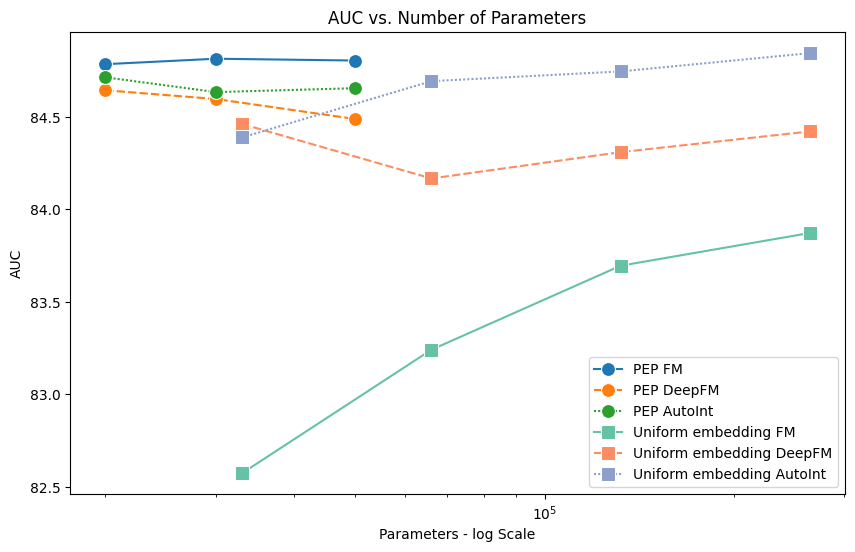

In [69]:

df_FM = pd.DataFrame({'parameters': [int(param) for param in dataframes[0][[1,2,3]].iloc[0]],
                           'AUC': [auc[0]*100 for auc in dataframes[0][[1,2,3]].iloc[1]],
                           'Model': 'PEP FM'})

df_deepFM = pd.DataFrame({'parameters': [int(param) for param in dataframes[1][[1,2,3]].iloc[0]],
                          'AUC': [auc[0]*100 for auc in dataframes[1][[1,2,3]].iloc[1]],
                          'Model': 'PEP DeepFM'})

df_autoint = pd.DataFrame({'parameters': [int(param) for param in dataframes[2][[1,2,3]].iloc[0]],
                          'AUC': [auc[0]*100 for auc in dataframes[2][[1,2,3]].iloc[1]],
                          'Model': 'PEP AutoInt'})




# Combine DataFrames
df = pd.concat([df_FM,df_deepFM,df_autoint])

# Plot the data with separate calls for each model (specifying color and marker)
plt.figure(figsize=(10, 6))
# Plot `df` with one color palette
sns.lineplot(
    x='parameters', y='AUC', hue='Model', data=df, 
    style='Model', palette='tab10', marker='o', markersize=10
)

# Plot `df_uniform` with another color palette
sns.lineplot(
    x='parameters', y='AUC', hue='Model', data=df_uniform, 
    style='Model', palette='Set2', marker='s', markersize=10
)

# Customize the plot
# Set x-axis to log scale


# Add custom ticks for the x-axis
plt.xscale('log')
plt.xlabel('Parameters - log Scale')
plt.ylabel('AUC')
plt.title('AUC vs. Number of Parameters')

# Re-order legend entries to match line order (optional)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Show the plot
plt.show()

In [6]:
import os
os.listdir()

['.git',
 'autoInt_PEP_retrain[20000,29999,49997].csv',
 'data',
 'data_loader',
 'Deepfm_PEP_retrain[20000,30000,49988].csv',
 'engine.py',
 'FM_PEP_retrain_[20000, 29997, 49997].csv',
 'models',
 'README.md',
 'tmp',
 'train_avazu.py',
 'train_avazu_retrain.py',
 'train_criteo.ipynb',
 'train_criteo.py',
 'train_criteo_retrain.py',
 'train_ml-1m.py',
 'train_ml-1m_retrain.py',
 'train_ml.ipynb',
 'utils',
 '__pycache__']